<a href="https://colab.research.google.com/github/jm7n7/comp-vis-hw2-log-key-point-detection/blob/main/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow # For displaying images in Colab
from scipy.ndimage import maximum_filter, minimum_filter

# set default figure size for matplotlib
plt.rcParams['figure.figsize'] = [10, 8]

##Part 1: LoG Pyramid

In [2]:
# --- Function Definition for Q1 ---
def getLoGPyramid(image, scales):
    """
    Computes the Laplacian of Gaussian (LoG) pyramid for a given image and scales.

    Args:
        image (np.array): The input image.
        scales (list or np.array): A list of sigma values for the Gaussian filter.

    Returns:
        np.array: A 3D numpy array of shape (height, width, num_scales)
                  containing the LoG responses.
    """
    # 1. Preprocessing: Convert to grayscale and float, then normalize
    if len(image.shape) > 2:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image

    # It's better to work with floating point images for precision
    float_image = gray_image.astype(np.float32) / 255.0

    # 2. Loop through scales and build the pyramid
    log_pyramid = []
    for sigma in scales:
        # 3. Apply Gaussian Blur
        # A good kernel size is about 6 times sigma
        ksize = 2 * int(np.ceil(3 * sigma)) + 1
        blurred_image = cv2.GaussianBlur(float_image, (ksize, ksize), sigmaX=sigma, sigmaY=sigma)

        # 4. Apply Laplacian Filter and Normalize
        # The result is multiplied by sigma^2 for scale normalization
        log_response = sigma**2 * cv2.Laplacian(blurred_image, ddepth=cv2.CV_32F, ksize=3)

        log_pyramid.append(log_response)

    # 5. Stack the pyramid into a single 3D numpy array
    return np.stack(log_pyramid, axis=-1)

In [4]:
# 1. Load the test image
try:
    image = cv2.imread('flarsheim-1.jpg')
    if image is None:
        raise FileNotFoundError("Make sure image is uploaded to your Colab environment!")
    print("Image loaded successfully!")
except FileNotFoundError as e:
    print(e)
    # Create a dummy image if not found, so the script doesn't crash
    image = np.zeros((200, 200, 3), dtype=np.uint8)

Image loaded successfully!


In [5]:
# 2. Define the scales from the assignment document
scales = np.array([1.200, 1.518, 1.920, 2.429, 3.072, 3.886, 4.915])

In [6]:
# 3. Compute the LoG Pyramid
log_pyramid_responses = getLoGPyramid(image, scales)
print(f"Computed LoG Pyramid. Shape: {log_pyramid_responses.shape}")

Computed LoG Pyramid. Shape: (430, 630, 7)



--- Visualizing Results ---


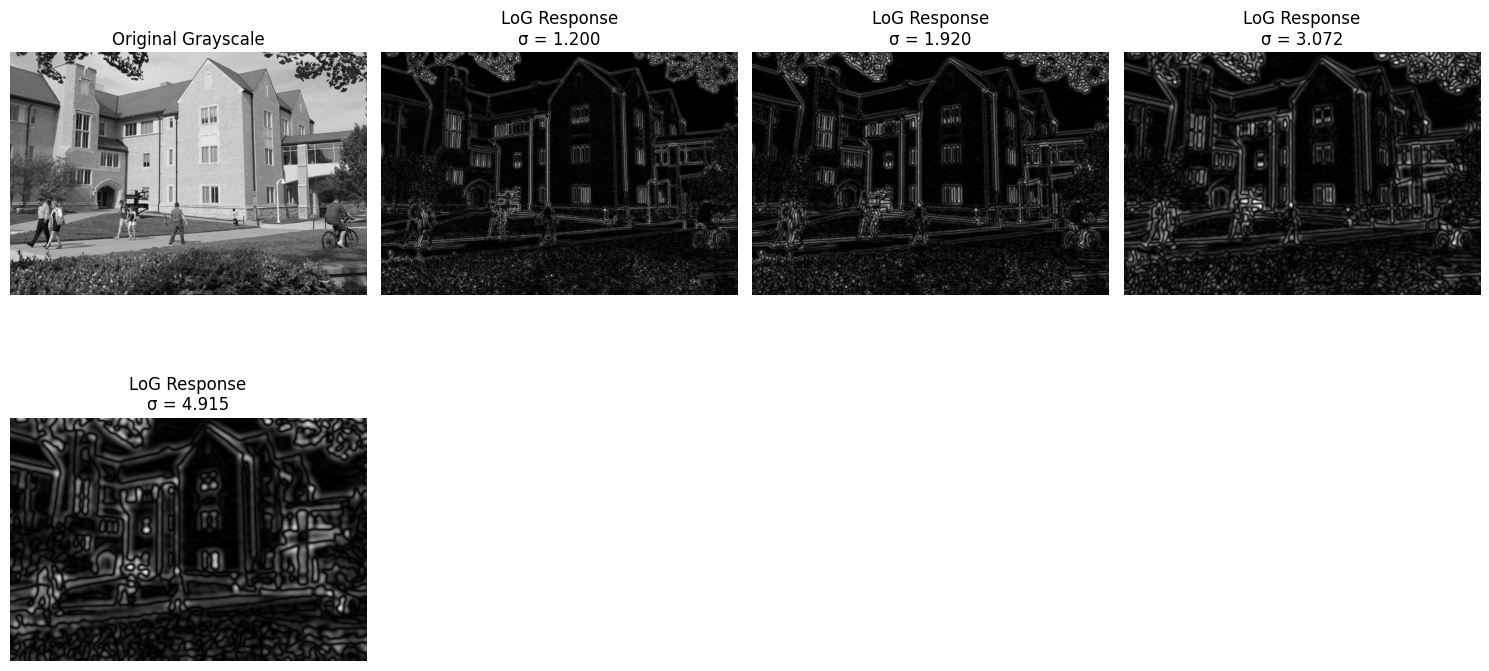

In [7]:
# 4. Verification: Visualize the results
# Let's display the original image and a few layers of the LoG pyramid
print("\n--- Visualizing Results ---")
plt.figure(figsize=(15, 8))

# Original Grayscale Image
plt.subplot(2, 4, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), cmap='gray')
plt.title('Original Grayscale')
plt.axis('off')

# Displaying 4 of the 7 layers
indices_to_show = [0, 2, 4, 6]
for i, layer_idx in enumerate(indices_to_show):
    plt.subplot(2, 4, i + 2)
    # We use the absolute value for visualization to see both positive and negative responses
    response_to_show = np.abs(log_pyramid_responses[:, :, layer_idx])
    plt.imshow(response_to_show, cmap='gray')
    plt.title(f'LoG Response\nσ = {scales[layer_idx]:.3f}')
    plt.axis('off')

plt.tight_layout()
plt.show()

## Part 2: LoG Response Extrema

In [23]:
# --- Function Definition for Q2 ---
def getScaleResponseExtrema(scales, responses):
    """
    Fits a 3rd-degree polynomial to the LoG responses, finds the maximum,
    and computes the derivative at that maximum.

    Args:
        scales (np.array): The array of sigma values used (x-values).
        responses (np.array): The LoG responses for a single pixel (y-values).

    Returns:
        tuple: A tuple containing:
            - x0 (float): The refined scale (sigma) that maximizes the response.
            - y_max (float): The peak response value at the refined scale.
            - deriv_at_max (float): The value of the derivative at x0.
    """
    # 1. Polynomial Fitting: y = ax^3 + bx^2 + cx + d
    p_coeffs = np.polyfit(scales, responses, 3)
    poly_func = np.poly1d(p_coeffs)

    # 2. Find the Maximum of the Fitted Curve (Numerical Method)
    fine_grained_scales = np.linspace(scales[0], scales[-1], 100)
    fine_grained_responses = poly_func(fine_grained_scales)
    max_index = np.argmax(fine_grained_responses)
    x0 = fine_grained_scales[max_index]
    y_max = fine_grained_responses[max_index]

    # 3. Compute the Derivative at the Maximum
    # The derivative of the polynomial is 3ax^2 + 2bx + c
    deriv_coeffs = np.polyder(p_coeffs)
    deriv_func = np.poly1d(deriv_coeffs)
    deriv_at_max = deriv_func(x0)

    return x0, y_max, deriv_at_max

In [24]:
# Let's pick a sample pixel to test our updated function.
# For example, a pixel near the center of the building.
px_y, px_x = 250, 350

# Extract the 7 LoG responses for this specific pixel from our pyramid.
pixel_responses = log_pyramid_responses[px_y, px_x, :]

# ✨ FIX: Unpack all three returned values from the updated function ✨
refined_scale, peak_response, deriv_at_max = getScaleResponseExtrema(scales, pixel_responses)

print(f"--- Testing for pixel ({px_y}, {px_x}) ---")
print(f"Original responses: {np.round(pixel_responses, 2)}")
print(f"Found peak response of {peak_response:.2f} at refined scale σ = {refined_scale:.3f}")
print(f"The derivative at this peak is: {deriv_at_max:.4f}")

# You can also add a check to see if this pixel would pass the gradient threshold
gradient_threshold = 0.2
if abs(deriv_at_max) < gradient_threshold:
    print("This keypoint PASSES the gradient threshold check.")
else:
    print("This keypoint FAILS the gradient threshold check.")

--- Testing for pixel (250, 350) ---
Original responses: [ 0.21  0.17  0.08 -0.07 -0.25 -0.36 -0.31]
Found peak response of 0.22 at refined scale σ = 1.200
The derivative at this peak is: -0.1560
This keypoint PASSES the gradient threshold check.


In [25]:
# Create the polynomial and derivative functions for plotting
p_coeffs = np.polyfit(scales, pixel_responses, 3)
poly_func = np.poly1d(p_coeffs)
deriv_func = np.poly1d(np.polyder(p_coeffs)) # Get derivative function

# Create a fine-grained set of scales for smooth curves
fine_grained_scales = np.linspace(scales[0], scales[-1], 100)
fine_grained_responses = poly_func(fine_grained_scales)
derivative_values = deriv_func(fine_grained_scales)

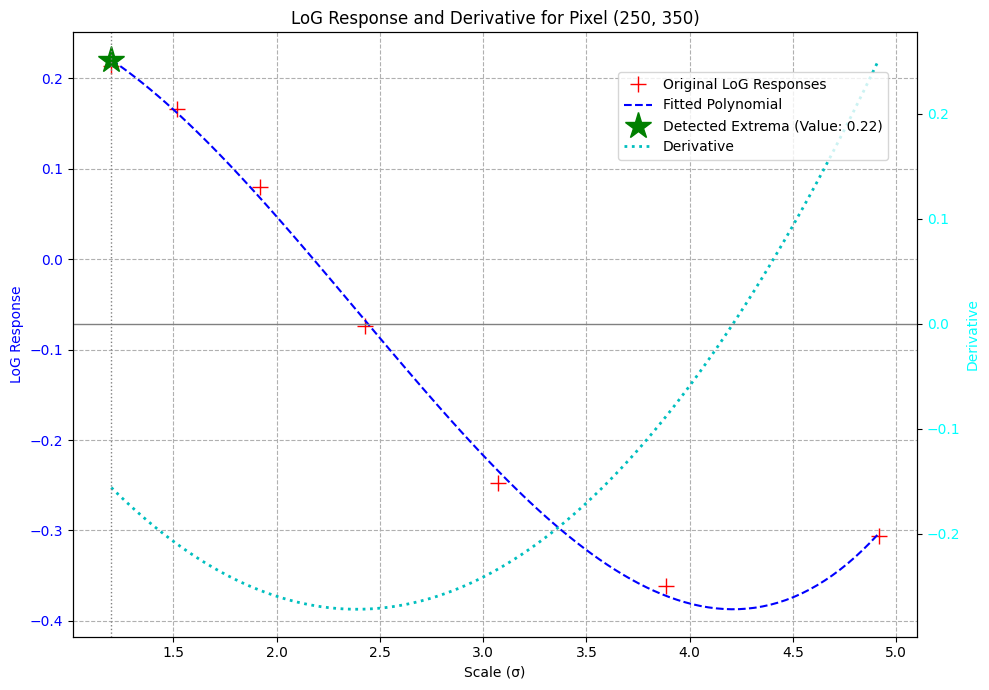

In [26]:
# Setup plot with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 7))

# Plotting the main LoG response data on the left y-axis (ax1)
ax1.set_xlabel('Scale (σ)')
ax1.set_ylabel('LoG Response', color='blue')
ax1.plot(scales, pixel_responses, 'r+', markersize=12, label='Original LoG Responses')
ax1.plot(fine_grained_scales, fine_grained_responses, 'b--', label='Fitted Polynomial')
ax1.plot(refined_scale, peak_response, 'g*', markersize=20, label=f'Detected Extrema (Value: {peak_response:.2f})')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--')

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Derivative', color='cyan')
# Plotting the derivative on the right y-axis (ax2)
ax2.plot(fine_grained_scales, derivative_values, 'c:', linewidth=2, label='Derivative')
ax2.tick_params(axis='y', labelcolor='cyan')

# Add a horizontal line at y=0 for the derivative to easily see the zero-crossing
ax2.axhline(0, color='gray', linestyle='-', linewidth=1)

# Add a vertical line to show where the peak was found
plt.axvline(x=refined_scale, color='gray', linestyle=':', linewidth=1)

# Final plot details
plt.title(f'LoG Response and Derivative for Pixel ({px_y}, {px_x})')
fig.tight_layout()
# Ask matplotlib to create a single legend for all plotted items
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
plt.show()

## Part 3: Image Level LoG Key Point Detection

In [27]:
# --- Function Definition for Q3 ---
def getLoGPyramid(image, scales):
    if len(image.shape) > 2:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image
    float_image = gray_image.astype(np.float32) / 255.0
    log_pyramid = []
    for sigma in scales:
        ksize = 2 * int(np.ceil(3 * sigma)) + 1
        blurred_image = cv2.GaussianBlur(float_image, (ksize, ksize), sigmaX=sigma, sigmaY=sigma)
        log_response = sigma**2 * cv2.Laplacian(blurred_image, ddepth=cv2.CV_32F, ksize=3)
        log_pyramid.append(log_response)
    return np.stack(log_pyramid, axis=-1)


# --- Updated Function from Step 1 ---
def getScaleResponseExtrema(scales, responses):
    p_coeffs = np.polyfit(scales, responses, 3)
    poly_func = np.poly1d(p_coeffs)
    fine_grained_scales = np.linspace(scales[0], scales[-1], 100)
    fine_grained_responses = poly_func(fine_grained_scales)
    max_index = np.argmax(fine_grained_responses)
    x0 = fine_grained_scales[max_index]
    y_max = fine_grained_responses[max_index]
    deriv_coeffs = np.polyder(p_coeffs)
    deriv_func = np.poly1d(deriv_coeffs)
    deriv_at_max = deriv_func(x0)
    return x0, y_max, deriv_at_max


# --- Final, Updated Keypoint Detector ---
def getLoGKeyPoints(image, log_peak_thres, grad_thres):
    """
    Detects keypoints using both a peak strength and gradient threshold.
    """
    # 1. Get the LoG Pyramid
    print("Step 1: Computing LoG pyramid...")
    scales_arr = np.array([1.200, 1.518, 1.920, 2.429, 3.072, 3.886, 4.915])
    log_pyramid = getLoGPyramid(image, scales_arr)

    # 2. Find Candidate Keypoints
    print("Step 2: Finding candidate keypoints...")
    local_maxima = maximum_filter(log_pyramid, size=(3, 3, 3)) == log_pyramid
    local_minima = minimum_filter(log_pyramid, size=(3, 3, 3)) == log_pyramid
    candidate_points = local_maxima | local_minima
    candidate_points[0, :, :] = candidate_points[-1, :, :] = False
    candidate_points[:, 0, :] = candidate_points[:, -1, :] = False
    candidate_points[:, :, 0] = candidate_points[:, :, -1] = False
    candidate_coords = np.argwhere(candidate_points)

    # 3. Filter and Refine Candidates
    print(f"Step 3: Refining {len(candidate_coords)} candidates with new thresholds...")
    final_keypoints = []
    for r, c, scale_idx in candidate_coords:
        responses = log_pyramid[r, c, :]

        # First thresholding on peak strength
        if np.abs(responses[scale_idx]) > log_peak_thres:
            # Refine and get the derivative
            refined_scale, peak_response, deriv_at_max = getScaleResponseExtrema(scales_arr, responses)

            # ✨ NEW: Second thresholding on the gradient ✨
            if np.abs(deriv_at_max) < grad_thres:
                final_keypoints.append((c, r, refined_scale)) # Store as (x, y, scale)

    print(f"Found {len(final_keypoints)} final keypoints after all filtering.")
    return final_keypoints

In [60]:
# Define the thresholds from the paper
log_peak_threshold = 0.25
gradient_threshold = 0.0005 # The new threshold, G_th

# Run the updated main function
log_keypoints = getLoGKeyPoints(image, log_peak_threshold, gradient_threshold)

Step 1: Computing LoG pyramid...
Step 2: Finding candidate keypoints...
Step 3: Refining 3569 candidates with new thresholds...
Found 189 final keypoints after all filtering.



--- Visualizing Final Results ---


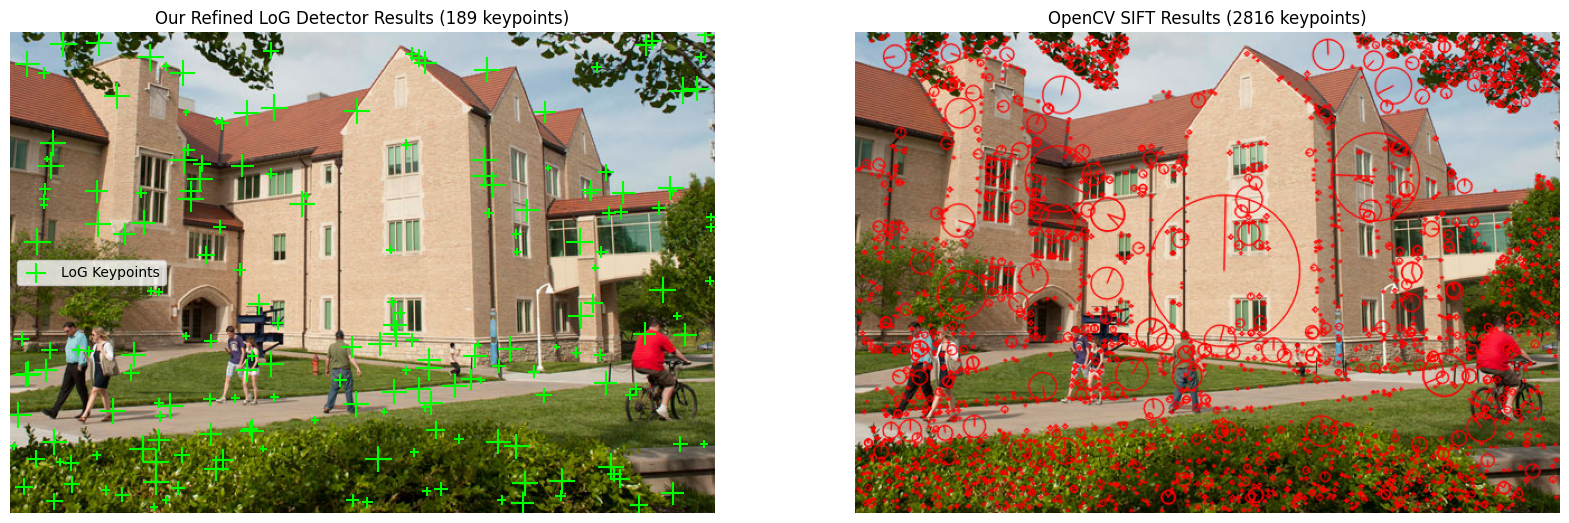

In [61]:
# --- Visualization ---
print("\n--- Visualizing Final Results ---")
image_rgb_log = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(image_rgb_log)
plt.title(f'Our Refined LoG Detector Results ({len(log_keypoints)} keypoints)')
plt.axis('off')

if log_keypoints: # Check if there are any keypoints to plot
    x_coords = [kp[0] for kp in log_keypoints]
    y_coords = [kp[1] for kp in log_keypoints]
    scales_for_size = [kp[2] for kp in log_keypoints]
    marker_sizes = [(s * 4)**2 for s in scales_for_size]
    plt.scatter(x_coords, y_coords, s=marker_sizes, marker='+', color='lime', linewidths=1.5, label='LoG Keypoints')
    plt.legend()


# Compare with SIFT
sift = cv2.SIFT_create()
sift_keypoints = sift.detect(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), None)
image_with_sift_keypoints = cv2.drawKeypoints(image, sift_keypoints, None, color=(0, 0, 255), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image_with_sift_keypoints, cv2.COLOR_BGR2RGB))
plt.title(f'OpenCV SIFT Results ({len(sift_keypoints)} keypoints)')
plt.axis('off')

plt.show()